In [1]:
import matplotlib.pyplot as plt
from collections import namedtuple, defaultdict
from copy import deepcopy
from simple_pid import PID
import random
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import pickle
from tqdm.notebook import tqdm
from typing import List

# Implementation of an Ad Delivery Simulator 

## Helpers

In [2]:
Candidate = namedtuple('Candidate', ['id', 'composite_score', 'acc_rate'])
Request = namedtuple('Request', ['idx', 'publisher_id', 'expense', 'candidates'])
Eligibility = namedtuple('Eligibility', ['publisher', 'from_time', 'to_time', 'eligible_campaigns'])

SampleSchedule = namedtuple('SampleSchedule', ['time', 'nb_expected'])

InventorySchedule = namedtuple('DeliveryInventory', ['publisher', 'inventories_schedule'])
CampaignSchedule  = namedtuple('CampaignSchedule',  ['campaign_id', 'schedule', 'start_minute', 'end_minute'])


In [3]:
def boundValue(val, min_v, max_v):
    return min(max(min_v, val), max_v)

def format_time(minute_val):
    # convert minutes to format hh:mm 
    hours = minute_val // 60
    minutes = minute_val % 60
    return f"{int(hours):02d}:{int(minutes):02d}"
    
def parse_time(time_str):
    # convert time from format hh:mm to minutes
    hours, minutes = map(int, time_str.split(':'))
    return hours * 60 + minutes

## Speed Regulator 

The `Speed_Regulator` class is designed to dynamically manage and adjust the campaign threshold. This adjustment is based on the observed delay, which is the ratio between the expected budget and the actual budget. The class implements two distinct strategies for regulation:

- **PID Regulator:** This method utilizes a Proportional-Integral-Derivative ([PID](https://fr.wikipedia.org/wiki/R%C3%A9gulateur_PID#:~:text=Le%20r%C3%A9gulateur%20PID%2C%20appel%C3%A9%20aussi,ou%20proc%C3%A9d%C3%A9%20en%20boucle%20ferm%C3%A9e.)) controller, a widely recognized control mechanism in automation and process control industries. The PID regulator continuously adjusts the campaign threshold to optimise the delay, thus aligning the actual budget closely with the expected budget.

- **Custom Approach:** In addition to the PID regulator, the class also offers a custom strategy. This approach focuses primarily on the proportional and derivative components of the control process. It is tailored to handle specific scenarios where a customized response to the delay is more effective.



In [4]:
class Speed_Regulator:
    
    def __init__(self, expected, init, p_factor, kp, ki, kd, max_bound):
        # Initialization of variables
        self.delay = 1
        self.threshold = init
        self.pid = PID(Kp=kp, Ki=ki, Kd=kd, setpoint=1.0, sample_time=None)
        self.p_factor = p_factor
        self.max_bound = max_bound
        self.expected = expected
        self.expected_tot = expected[-1]

        self.accumulator = 0
        self.minute = 0
        self.history = [(self.delay, self.threshold)]

    def regulate_pid(self, new_delay):
        # PID regulation based on new delay
        return self.pid(new_delay, 60)
    
    def regulate_current(self, new_delay):
        # Regulation with custom strategy
        error = new_delay - 1
        delay_variation = self._bound_value(new_delay - self.delay, -0.1, 0.1)
        thresholdMultiplier = max(1, self.threshold)
        return thresholdMultiplier * self.p_factor * (error + 10 * delay_variation)

    def update(self, incr):
        # Updating the regulator with new increment
        self.accumulator += incr
        new_delay = self._compute_delay()
        control = self.regulate_pid(new_delay)  # or use regulate_current(new_delay)
        self.threshold = self._bound_value(self.threshold + control, 0, self.max_bound)
        self.delay = new_delay
        self.minute += 1
        self.history.append((self.delay, self.threshold))
        return self.threshold

    def _compute_delay(self):
        # Helper method to calculate new delay
        return self.accumulator / self.expected[self.minute] if self.expected[self.minute] > 0 else 1

    def _bound_value(self, value, min_val, max_val):
        # Helper method to bound a value within min and max limits
        return max(min(value, max_val), min_val)

    def get_reach(self):
        # Calculating the reach percentage
        return min(self.accumulator / self.expected_tot, 1)


## Speed Threshold Simplified

The `Campaign_Regulators` class is used to manage all the delivery campaigns pacing using individual Speed_Regulator instances for each campaign.

In [5]:
class Campaign_Regulators:
    
    def __init__(self, expected_dict, init=3, p_factor=0.05, kp=-0.08, ki=-2.2727272727272726e-7, kd=-110, max_bound=5):
        # Initializing regulators for each campaign
        self.regulators = {}
        for campaign_id, expected in expected_dict.items():
            self._initialize_regulator(campaign_id, expected, init, p_factor, kp, ki, kd, max_bound)

    def _initialize_regulator(self, campaign_id, expected, init, p_factor, kp, ki, kd, max_bound):
        # Helper method to initialize a speed regulator for a campaign
        self.regulators[campaign_id] = Speed_Regulator(expected, init, p_factor, kp, ki, kd, max_bound)

    def update_regulators(self, increments):
        # Update each regulator with the corresponding increment
        for campaign_id, regulator in self.regulators.items():
            increment = increments.get(campaign_id, 1)
            regulator.update(increment)

## Delivery System Simplified

The `Delivery_System` is the central component of the simulator, emulating a simplified Ad Delivery System and the Speed-Threshold Algorithm. This class is responsible for managing and pairing of ad requests across various campaigns, leveraging the capabilities of the `Campaign_Regulators` to dynamically adjust campaign delivery. It considers predefined criteria and real-time performance data, particularly focusing on the campaigns' delay.


Key functionalities of the `Delivery_System` include:
- **Campaign Delivery Pacing**: It manages the pacing of ad deliveries for individual campaigns through the integration with `Campaign_Regulators`.
- **Campaign Eligibility Filtering**: The system filters campaigns to identify those eligible for delivery. This process is based on their performance relative to set campaign thresholds.
- **Candidate Selection for Ad Requests**: From a pool of campaign candidates, the `Delivery_System` selects the most appropriate one for each delivery request.
- **Performance Tracking and Adjustment**: The class tracks key performance metrics, such as requests and impressions, to continuously monitor and fine-tune campaign performance. It operates under the assumption that the number of accomplished events (like clicks or views) is influenced by a probability inherent to each campaign.

In [6]:
class Delivery_System:
    
    def __init__(self, np_expected_campaigns):
        self.campaigns_speeds = Campaign_Regulators(deepcopy(np_expected_campaigns))
        self.campaigns_sum_scores = defaultdict(int)
        self.campaigns_accomplishes = defaultdict(int)
        self.tot_publishers_exps = defaultdict(int)
        self.minute = 0
        self._reset_temp_counters()

    def _reset_temp_counters(self):
        # Resets temporary counters for campaigns and publishers
        self.campaigns_imps = defaultdict(int)
        self.publishers_exps = defaultdict(int)
        self.nb_reqs = 0
        self.nb_imps = 0

    def update_regulators(self, display):
        # Updates the regulators and resets counters
        nb_imps = self.nb_imps
        self.campaigns_speeds.update_regulators(self.campaigns_imps)
        self._reset_temp_counters()
        self.minute += 1
        return nb_imps

    def is_campaign_allowed_to_pass(self, campaign):
        # Checks if a campaign is allowed to pass based on its score and threshold
        campaign_id = campaign.id
        composite_score = float(campaign.composite_score)
        threshold = self.campaigns_speeds.regulators[campaign_id].threshold
        return campaign_id in self.campaigns_speeds.regulators and composite_score >= threshold

    def filter_candidates(self, candidates, publisher_id):
        # Filters candidates based on eligibility to pass
        return list(filter(self.is_campaign_allowed_to_pass, candidates))

    def select_winner(self, candidates):
        # Selects a random winner from the candidates
        return random.choice(candidates) if candidates else None

    def affect_next_request(self, candidates, request):
        # Processes the next ad request, updating various counts and metrics
        cat = request.publisher_id
        expense = request.expense
        
        self.nb_reqs += 1
        passing_candidates = self.filter_candidates(candidates, cat)
        winner = self.select_winner(passing_candidates)

        if winner:
            self.nb_imps += 1
            self.campaigns_imps[winner.id] += 1
            self.campaigns_accomplishes[winner.id] += winner.acc_rate
            self.campaigns_sum_scores[winner.id] += winner.composite_score
            self.publishers_exps[cat] += expense
            self.tot_publishers_exps[cat] += expense

        return winner

## Ad Delivery Simulator

The `Simulation` class functions as the central framework for simulating an Ad Delivery System, incorporating a speed-threshold algorithm to manage ad requests across different campaigns. Initialized with campaign targets and a sequence of ad requests, the class orchestrates several key processes. Key aspects of this class include:

- **Initialization**: The class is initialized with:
  - *Campaign targets* in `df_expected_campaigns`
  - A series of *ad requests* (with prior on each campaigns candidates)
  - These parameters set the stage for a comprehensive simulation.

- **Integration with `Delivery_System`**: 
  - The class leverages the `Delivery_System` to emulate the functioning of an ad delivery.
  - It evaluates each ad request, choosing the most suitable ad based on the **current performance** of campaigns and their thresholds.

- **Dynamic Campaign Regulation**: 
  - Updates of campaign regulators are implemented, ensuring the simulation reflects **real-time data and adjustments**.
  - This feature maintains a responsive and adaptive simulation environment.

- **Simulation Execution**:
  - Iterates through ad requests, applying adjustments and selecting Ad campaigns candidates.
  - Maintains a count of processed requests and provides periodic updates.

In [7]:
class Simulation:
    
    def __init__(self, df_expected_campaigns, requests):
        # Initializing simulation with campaign and request data
        self.df_expected = df_expected_campaigns
        np_expected_campaigns = self.df_expected.set_index('campaign_id').to_dict(orient='dict')['schedule']
        self.delivery_system = Delivery_System(np_expected_campaigns)
        self.requests = requests
        self.minute = 0
        self.nb_reqs = 0

    def _update_all_regulators(self):
        # Helper method to update all regulators
        display = self.minute % 100 == 0
        if display:
            print(f"Minute {self.minute} done, with {self.nb_reqs} reqs")
        nb_imps = self.delivery_system.update_regulators(display)
        if display:
            print(f"=> stats - {nb_imps} imps")

    def _affect_next_request(self, request):
        # Processes the next request in the simulation
        candidates = [Candidate(*candidate) for candidate in request.candidates]
        self.delivery_system.affect_next_request(candidates, request)

    def run_simulation(self):
        # Running the entire simulation for all requests
        for request in self.requests.itertuples(name="Request"):
            if request.idx != self.minute:
                self._updates_all(request.idx)

            self._affect_next_request(request)
            self.nb_reqs += 1

        # Final update after processing all requests
        self._update_all_regulators()

    def _updates_all(self, new_minute):
        # counters & regulators update
        for _ in range(new_minute - self.minute):
            self._update_all_regulators()
            self.minute += 1
            self.nb_reqs = 0


## Analysis Class

The `ResultsAnalysis` class plays a pivotal role in evaluating the performance of the `Simulation` class within a simulated Ad Delivery System. It provides critical insights into how the simulation aligns with expected campaign targets and real-time dynamics. Key functionalities of the `ResultsAnalysis` class include:

- **Campaign Data Compilation**: Gathers historical performance data and expected targets for each campaign from the simulation's delivery system.

- **Inventory Analysis**: Offers a comprehensive view of the inventory distribution across publishers over time, aiding in understanding the supply dynamics.

- **Campaign Performance Visualization**: Enables detailed visualization of individual campaign performance, highlighting the variations in pacing and regulatory adjustments throughout the simulation.

- **Comparative Campaign Analysis**: Provides tools to compare multiple campaigns simultaneously, assessing their performance relative to each other.

- **Enhanced Data Interpretation**: Employs various visualization techniques to present complex data in an easily interpretable format, enhancing the understanding of campaign behaviors and trends.

In [8]:
class ResultsAnalysis:
    
    def __init__(self, simulation, minutes=1440):
        self.simulation = simulation
        self.history = {
            campaign_id:reg.history 
            for campaign_id, reg in simulation.delivery_system.campaigns_speeds.regulators.items()
        }
        self.expected = {
            campaign_id:reg.expected 
            for campaign_id, reg in simulation.delivery_system.campaigns_speeds.regulators.items()
        }
        self.nb_minutes = minutes
        self.campaigns_conf = simulation.df_expected.set_index('campaign_id')[['start_minute', 'end_minute']].to_dict(orient='index')
    
    def _get_inventory_countdf(self):
        # Inventory Count per Publisher
        return self.simulation.requests\
                                  .groupby(['idx', 'publisher_id'])\
                                  .agg({'idx': "count"})\
                                  .rename(columns={'idx':'count'})\
                                  .reset_index()
    
    def _configure_axis(self, ax, title, xlabel, ylabel, legend_title):
        ax.set_title(title, fontsize=16)
        ax.set_xlabel(xlabel, fontsize=14)
        ax.set_ylabel(ylabel, fontsize=14)
        ax.legend(title=legend_title)
        ax.grid(True, which='both', linestyle='--', linewidth=0.3)
        x_ticks = np.arange(0, 1441, 60)
        ax.set_xticks(x_ticks)
        ax.set_xticklabels([format_time(m) for m in x_ticks])
        for label in ax.get_xticklabels():
            label.set_rotation(45)
            
    def _get_campaign_values(self, campaign_id, targets, cumulative):
        start = self.campaigns_conf[campaign_id]['start_minute']
        end = self.campaigns_conf[campaign_id]['end_minute']
        if not cumulative:
            start_value = np.diff(targets, 1, 0, 0)[start]
            end_value = np.diff(targets, 1, 0, 0)[end - 1]
            adjustment_step = 80 
        else:
            start_value = targets[start]
            end_value = targets[end - 1]
            adjustment_step = 5000 
        return start, end, start_value, end_value, adjustment_step
    
    def _plot_campaign_data(self, ax, minutes, start, end, campaign_id, targets, cumulative):
        if not cumulative:
            ax.plot(minutes[start:end], np.diff(targets, 1, 0, 0)[start:end], label=f'Campaign {campaign_id}')
        else:
            ax.plot(minutes[start:end], targets[start:end], label=f'Campaign {campaign_id}')

    def _annotate_campaign(self, ax, start, end, start_value, end_value, hstep=0.1, wstep=100):
        if start > 100:
            ax.annotate('New Campaign', xy=(start, start_value), xytext=(start - wstep, start_value - hstep),
                        arrowprops=dict(facecolor='gray', arrowstyle='->'),
                        horizontalalignment='center', verticalalignment='bottom')
        
        if end < 1439:
            ax.annotate('Stopped Campaign', xy=(end, end_value), xytext=(end - wstep, end_value - hstep), alpha=0.5,
                        arrowprops=dict(facecolor='gray', arrowstyle='->', alpha=0.3),
                        horizontalalignment='center', verticalalignment='bottom')

    def plot_inventories_curve(self, cumulative=False, figsize=(15, 12)):
        # Inventory Count per Publisher
        df_count = self._get_inventory_countdf()

        # get axis
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize)

        # Plotting Inventory Count per Publisher
        for publisher in df_count['publisher_id'].unique():
            publisher_data = df_count[df_count['publisher_id'] == publisher]
            ax1.plot(publisher_data['idx'], publisher_data['count'], label=publisher)

        self._configure_axis(ax1, title='Inventory Count per Minute by Publisher', xlabel='Time of Day', ylabel='Inventory Count', legend_title='Publisher ID')
    
        # Plotting Campaign Schedule
        minutes = range(1440)
        for campaign_id, targets in self.expected.items():
            # Get campaign values
            start, end, start_value, end_value, adjustment_step = self._get_campaign_values(campaign_id, targets, cumulative)
            # Plot the campaign data
            self._plot_campaign_data(ax2, minutes, start, end, campaign_id, targets, cumulative)
            # Annotate the campaign start and end
            self._annotate_campaign(ax2, start, end, start_value, end_value, adjustment_step, 200)

        self._configure_axis(ax2, title='Campaign Delivery Schedule', xlabel='Time of Day', ylabel='Target Value', legend_title='Campaign ID')
    
        plt.tight_layout()
        plt.show()
    
    def plot_campaign_evolution(self, item_id, label_control='threshold', figsize=(15, 12)):
        minutes = range(self.nb_minutes)
        
        start = self.campaigns_conf[item_id]['start_minute']
        end =  self.campaigns_conf[item_id]['end_minute']
        delay, threshold = zip(*self.history[item_id])
        delay_array = np.array(delay)

        fig, ax1 = plt.subplots(figsize=figsize)

        # Plotting delay on the left y-axis
        color_delay = 'tab:blue'
        ax1.set_xlabel('Time of Day')
        ax1.set_ylabel('Delay', color=color_delay)
        ax1.set_ylim(0, 1.2)
        ax1.plot(minutes[start:end], delay_array[start:end], color=color_delay)
        ax1.tick_params(axis='y', labelcolor=color_delay)
        ax1.set_yticks(np.arange(0, 1.5, 0.05))
        ax1.grid(True, which='both', linestyle='--', linewidth=0.3)
        

        # Add a horizontal dashed line at delay = 1
        ax1.axhline(y=1, color='tab:blue', linestyle='--', linewidth=1.5)

        ax1.annotate('Pacing Line', xy=(0.24, 1.01), xytext=(0.24, 0.9), color='tab:blue', alpha=0.5,
                     xycoords=('axes fraction', 'data'), textcoords='axes fraction',
                     arrowprops=dict(arrowstyle='->', color='tab:blue', linewidth=2, alpha=0.5),
                     horizontalalignment='center', verticalalignment='top')

        # Fill the area between the delay curve and the dashed line
        ax1.fill_between(minutes, delay_array, 1, where=(delay_array <= 1), facecolor='#FFA500', interpolate=True, alpha=0.3)
        ax1.fill_between(minutes, delay_array, 1, where=(delay_array > 1), facecolor='green', interpolate=True, alpha=0.3)

        # Create a second y-axis for threshold
        ax2 = ax1.twinx()
        color_threshold = 'tab:red'
        ax2.set_ylabel(label_control, color=color_threshold)
        ax2.set_ylim(0, 3.5)
        ax2.plot(minutes[start:end], threshold[start:end], color=color_threshold)
        ax2.tick_params(axis='y', labelcolor=color_threshold)

        fig.tight_layout()
        plt.show()
        
    def _plot_delay_or_threshold(self, ax, item_id, start, end, data, y_line, title, ylabel, minutes):
        ax.plot(minutes[start:end], data[start:end], label=f'{item_id}')
        if y_line is not None:
            ax.axhline(y=y_line, color='darkcyan', linestyle='--', linewidth=1.5)
            ax.annotate('Pacing Line', xy=(50, 1), xytext=(100, 1 + 0.2), alpha=0.4,
                         arrowprops=dict(facecolor='darkcyan', arrowstyle='->', edgecolor='darkcyan', linestyle='--', linewidth=1.5, alpha=0.4),
                         color='darkcyan', horizontalalignment='left', verticalalignment='bottom'
           )


        ax.set_title(title)
        ax.set_ylabel(ylabel)

    def _annotate_subplot_campaign_events(self, ax, start, end, start_value, end_value, hstep=0.1, wstep=100):
        if start > 100:
            ax.annotate('New Campaign', xy=(start, start_value), xytext=(start - wstep, start_value + hstep),
                        arrowprops=dict(facecolor='gray', arrowstyle='-|>'),
                        horizontalalignment='center', verticalalignment='bottom')
        if end < self.nb_minutes - 1:
            ax.annotate('Stopped Campaign', xy=(end, end_value), xytext=(end + wstep, end_value - hstep), alpha=0.5,
                        arrowprops=dict(facecolor='gray', arrowstyle='-|>', alpha=0.5),
                        horizontalalignment='center', verticalalignment='bottom')

    def _configure_subplot_axes_properties(self, ax, x_ticks, xlabel, ylabel, y_min, y_max):
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_xticks(x_ticks)
        ax.set_xticklabels([format_time(m) for m in x_ticks])
        ax.set_ylim(y_min, y_max)
        for label in ax.get_xticklabels():
            label.set_rotation(45)
        ax.legend(loc='best')
        ax.grid(True, which='both', linestyle='--', linewidth=0.3)

    def subplot_campaigns_evolution(self, item_ids, logscale=True, figsize=(15, 12)):
        minutes = range(self.nb_minutes)
        x_ticks = np.arange(0, self.nb_minutes, 60)

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize)

        for item_id in item_ids:
            start, end = self.campaigns_conf[item_id]['start_minute'], self.campaigns_conf[item_id]['end_minute']
            delay, threshold = zip(*self.history[item_id])
            delay_data = np.log(np.array(delay) + 1e-3) if logscale else np.array(delay)
            stopped_value = delay_data[end-1]

            self._plot_delay_or_threshold(ax1, item_id, start, end, delay_data, 0 if logscale else 1, 'Campaigns Delay (logarithmic scale) over Time' if logscale else 'Campaigns Delay over Time', 'Log Delay' if logscale else 'Delay', minutes)
            self._annotate_subplot_campaign_events(ax1, start, end, 1, stopped_value, 0.1, 100)

        self._configure_subplot_axes_properties(ax1, x_ticks, 'Time of Day', 'Delay', 0, 1.2)

        for item_id in item_ids:
            start, end = self.campaigns_conf[item_id]['start_minute'], self.campaigns_conf[item_id]['end_minute']
            _, threshold = zip(*self.history[item_id])
            self._plot_delay_or_threshold(ax2, item_id, start, end, threshold, None, 'Campaigns Threshold over Time', 'Threshold', minutes)
            self._annotate_subplot_campaign_events(ax2, start, end, 3, threshold[end-1], -0.3, 70)

        self._configure_subplot_axes_properties(ax2, x_ticks, 'Time of Day', 'Theshold', 0, 3.5)

        plt.tight_layout()
        plt.show()


## Generate Delivery Data for Simulation

The `MockData` class is an essential tool for simulating data in an Ad Delivery System, crucial for crafting realistic testing and analytical scenarios. Its features include:

- **Campaign Schedule Generation**: Offers two approaches to generating campaign schedules: one with a uniform budget across all campaigns, and another with diverse, randomly assigned schedules.

- **Campaign Candidates Generation for Ad Requests**: For each ad request, it generates a list of eligible campaign candidates. This process is driven by predefined campaigns eligibilities that evolves over time, effectively modeling changing priorities for in Ad Campaigns management.

- **Ad Requests Generation**: By interpolating the volume of ad requests across different times of the day, MockData creates a realistic sequence of ad requests, each populated with candidates with respect to Campaign Eligibility.

- **Ad Requests Updates and Re-prioritization**: Enables the modification of ad requests in response to new campaign eligibility criteria, allowing for the simulation of varied ad delivery scenarios while maintaining a consistent request volume.

- **Data Management**: Includes functions for saving and loading the generated mock data, facilitating easy data management and access for subsequent analysis.


In [9]:
class MockData:
    
    def __init__(self, nb_minutes):
        # Initialize with the total number of minutes for the simulation
        self.nb_minutes = nb_minutes


    def _interpolate_schedule(self, schedule_sample, start_time, end_time, kind):
        # Prepare data for interpolation for a specific publisher
        samples = [(parse_time(sample.time), sample.nb_expected) for sample in schedule_sample]
        s_min = parse_time(start_time)
        e_min = parse_time(end_time)
        # Interpolate inventories for the publisher and store the results for each minute
        f = interp1d(*zip(*samples), kind=kind, fill_value="extrapolate")
        interpolated_inventories = [ max(0, int(f(minute))) if (minute >= s_min and minute <= e_min) else 0 for minute in range(self.nb_minutes)]
        return interpolated_inventories
    
    
    
    def generate_campaign_schedule(self, campaign_sample, campaign_id, start_time='00:00', end_time='23:59', kind='cubic'):
        # Generate campaign schedules using the interpolate_schedules function
        interpolated_cmp_schedule = np.cumsum(self._interpolate_schedule(campaign_sample, start_time, end_time, kind))
        return CampaignSchedule(campaign_id, interpolated_cmp_schedule, parse_time(start_time), parse_time(end_time))
    
    
    def generate_inventory_schedule(self, inventories_sample, publisher, start_time='00:00', end_time='23:59', kind='cubic'):
        interpolated_inventories = self._interpolate_schedule(inventories_sample, start_time, end_time, kind)
        return InventorySchedule(publisher, interpolated_inventories)


    
    def _generate_candidate(self, cmp_id, category, req_cat, minute):
        # Generate a candidate if eligible for the given category and time
        candidate_eligible = category in req_cat[minute] if isinstance(req_cat, list) else category == req_cat[minute]
        return Candidate(cmp_id, random.random(), random.random()) if candidate_eligible else None

    def generate_candidates(self, campaign_eligibility, category="A", minute=0):
        # Generate a list of eligible candidates based on campaign eligibility
        return [candidate for cmp_id, req_cat in campaign_eligibility.items() if (candidate := self._generate_candidate(cmp_id, category, req_cat, minute))]

    
    def _derive_campaign_eligibility(self, campaign_eligibilities: List[Eligibility]):
        # Find all unique campaigns from the input list
        all_campaigns = {cmp for elm in campaign_eligibilities for cmp in elm.eligible_campaigns}

        # Initialize the result dictionary with empty lists for each minute of the day
        res = {campaign: [[] for _ in range(1440)] for campaign in all_campaigns}

        # Get the for each campaign at each minute, the pub where its is eligible to
        for eligibility in campaign_eligibilities:
            start_minute = parse_time(eligibility.from_time)
            end_minute = parse_time(eligibility.to_time)
            for campaign in eligibility.eligible_campaigns:
                for minute in range(start_minute, end_minute):
                    res[campaign][minute].append(eligibility.publisher)
        return res


    def generate_requests(self, delivery_inventories, eligibility_publishers):
        # Get campaign eligibility
        campaign_eligibility = self._derive_campaign_eligibility(eligibility_publishers)

        # Generate ad requests based on the precomputed delivery inventories
        inventories = []
        for minute in tqdm(range(self.nb_minutes)):
            for delivery_inventory in delivery_inventories:
                nb_reqs = delivery_inventory.inventories_schedule[minute]
                inventories.extend([self._create_request(minute, campaign_eligibility, delivery_inventory.publisher) for _ in range(nb_reqs)])
        return pd.DataFrame(inventories)

    def _create_request(self, minute, campaign_eligibility, publisher):
        # Helper method to create an individual ad request
        candidates = self.generate_candidates(campaign_eligibility, publisher, minute)
        return Request(minute, publisher, random.random(), candidates)



    def update_requests_cmp_prio(self, df_requests, new_campaign_eligibility):
        # Update ad requests based on new campaign priorities
        df_count = df_requests.groupby(['idx', 'publisher_id']).agg({'idx': "count"}).rename(columns={'idx':'counts'}).reset_index()
        updated_inventories = [self._update_individual_request(row, new_campaign_eligibility) for _, row in df_count.iterrows() for _ in range(row.counts)]
        return pd.DataFrame(updated_inventories)

    def _update_individual_request(self, row, new_campaign_eligibility):
        # Helper method to update an individual ad request based on new eligibility
        candidates = self.generate_candidates(new_campaign_eligibility, row.publisher_id, row.idx)
        return Request(row.idx, row.publisher_id, random.random(), candidates)

    def save_mocked_data(self, df_expected, df_requests, fpath='./blog_simu_data'):
        # Save the generated mock data to files
        os.makedirs(fpath, exist_ok=True)
        pickle.dump(df_requests, open(os.path.join(fpath, 'requests.pkl'), 'wb'))
        pickle.dump(df_expected, open(os.path.join(fpath, 'campaigns.pkl'), 'wb'))

    def load_dfs(self, fpath="./blog_simu_data"):
        # Load mock data from files
        return {
            "requests": pickle.load(open(os.path.join(fpath, 'requests.pkl'), 'rb')),
            "campaigns": pickle.load(open(os.path.join(fpath, 'campaigns.pkl'), 'rb')),
        }


# Let's bring it all together





In this section, we put all the simulation components together to assess various ad delivery scenarios. The section is structured into four distinct scenarios, each simulating different conditions in ad campaign delivery and publisher inventory allocation. 

Those scenarios highlight the intricacies of the Ad Delivery System with the Speed Threshold Algorithm namely the priority management between campaigns, the dynamic nature of the delivery with arrival or removal of campaigns during the delivery day etc...)

- **Scenario 1**: Tests a baseline situation where all campaigns have equal access to inventories from both publishers.
- **Scenario 2**: Simulates an exclusive allocation scenario, where publisher "B"’s inventories are dedicated solely to campaign C2.
- **Scenario 3**: Builds on Scenario 2 by introducing new campaigns (C5 and C6) at specific times, creating a competitive environment for C2 in accessing publisher “B”’s inventories.
- **Scenario 4**: Further evolves Scenario 3 by simulating the abrupt cessation of campaigns C3 and C4 at predetermined times during the day.

Each scenario unfolds in four main steps:

1. **Campaign Schedule Generation**: The `MockData` component generates campaign schedules, setting the stage for each scenario.
2. **Ad Request Generation**: This involves creating sample points for the volume curve of ad requests over the day, followed by interpolating these volumes across all time steps.
3. **Simulation Execution**: Using the generated ad requests and campaign schedules, a full day of delivery is simulated to understand how different scenarios play out in practice.
4. **Results Analysis**: Post-simulation, the outcomes are analyzed. This includes examining campaign delivery pacing, threshold adherence, and schedule curves, providing insights into the effectiveness of each scenario.





## Ideal Case

##### Generate campaign curve

In [10]:
%%time
# create data generator entity
mocked_data = MockData(1440)

# create sample schedule for cmp1
cmp_schedule_sample1 = [
     SampleSchedule(time='00:00', nb_expected=300),
     SampleSchedule(time='02:00', nb_expected=299),
     SampleSchedule(time='05:00', nb_expected=23),
     SampleSchedule(time='08:00', nb_expected=294),
     SampleSchedule(time='10:00', nb_expected=285),
     SampleSchedule(time='12:00', nb_expected=271),
     SampleSchedule(time='16:00', nb_expected=211),
     SampleSchedule(time='18:00', nb_expected=163),
     SampleSchedule(time='20:00', nb_expected=100),
     SampleSchedule(time='22:00', nb_expected=200),
     SampleSchedule(time='23:59', nb_expected=212),
]

# create sample schedule for cmp2
cmp_schedule_sample2 = [
    SampleSchedule(time=s.time, nb_expected=int(s.nb_expected * 1.15)) 
    for s in cmp_schedule_sample1
]


# create sample schedule for cmp3
cmp_schedule_sample3 = [
    SampleSchedule(time=s.time, nb_expected=int(s.nb_expected * 1.25)) 
    for s in cmp_schedule_sample1
]


# create sample schedule for cmp4
cmp_schedule_sample4 = [
    SampleSchedule(time=s.time, nb_expected=int(s.nb_expected * 0.85)) 
    for s in cmp_schedule_sample1
]


# generate campaigns schedule (for 4 campaigns)
cmp_schedule1 = mocked_data.generate_campaign_schedule(cmp_schedule_sample1, 'campaign1')
cmp_schedule2 = mocked_data.generate_campaign_schedule(cmp_schedule_sample2, 'campaign2')
cmp_schedule3 = mocked_data.generate_campaign_schedule(cmp_schedule_sample3, 'campaign3')
cmp_schedule4 = mocked_data.generate_campaign_schedule(cmp_schedule_sample4, 'campaign4')

df_expected = pd.DataFrame([cmp_schedule1, cmp_schedule2, cmp_schedule3, cmp_schedule4])

CPU times: user 93.9 ms, sys: 14.8 ms, total: 109 ms
Wall time: 104 ms


##### Generate requests curves

In [11]:
%%time
## define campaigns eligibility during the day
campaigns = ['campaign1', 'campaign2', 'campaign3', 'campaign4']
eligibities = [
    Eligibility(publisher='A', from_time='00:00', to_time='23:59', eligible_campaigns=campaigns),
    Eligibility(publisher='B', from_time='00:00', to_time='23:59', eligible_campaigns=campaigns)
]

inv_sample1 = [
     SampleSchedule(time='00:00', nb_expected=171),
     SampleSchedule(time='02:00', nb_expected=1194),
     SampleSchedule(time='05:00', nb_expected=601),
     SampleSchedule(time='08:00', nb_expected=742),
     SampleSchedule(time='10:00', nb_expected=918),
     SampleSchedule(time='12:00', nb_expected=624),
     SampleSchedule(time='16:00', nb_expected=1169),
     SampleSchedule(time='18:00', nb_expected=1051),
     SampleSchedule(time='20:00', nb_expected=392),
     SampleSchedule(time='22:00', nb_expected=1077),
     SampleSchedule(time='23:59', nb_expected=550),
 ]

inv_sample2 = [
    SampleSchedule(time=s.time, nb_expected=int(s.nb_expected * 1.07)) 
    for s in inv_sample1
]

invs1 = mocked_data.generate_inventory_schedule(publisher='A', inventories_sample=inv_sample1)
invs2 = mocked_data.generate_inventory_schedule(publisher='B', inventories_sample=inv_sample2)


## df requests
df_requests = mocked_data.generate_requests(
    delivery_inventories=[invs1, invs2], 
    eligibility_publishers=eligibities
)


  0%|          | 0/1440 [00:00<?, ?it/s]

CPU times: user 20.2 s, sys: 1.02 s, total: 21.2 s
Wall time: 21.3 s


##### Run delivery simulation

In [12]:
%%time
# simulation
simulation = Simulation(df_expected, df_requests)
simulation.run_simulation()

Minute 0 done, with 353 reqs
=> stats - 0 imps
Minute 100 done, with 2397 reqs
=> stats - 2396 imps
Minute 200 done, with 2107 reqs
=> stats - 267 imps
Minute 300 done, with 1244 reqs
=> stats - 60 imps
Minute 400 done, with 1165 reqs
=> stats - 567 imps
Minute 500 done, with 1643 reqs
=> stats - 1426 imps
Minute 600 done, with 1900 reqs
=> stats - 1419 imps
Minute 700 done, with 1367 reqs
=> stats - 766 imps
Minute 800 done, with 1405 reqs
=> stats - 1243 imps
Minute 900 done, with 2059 reqs
=> stats - 1641 imps
Minute 1000 done, with 2535 reqs
=> stats - 73 imps
Minute 1100 done, with 1918 reqs
=> stats - 669 imps
Minute 1200 done, with 811 reqs
=> stats - 453 imps
Minute 1300 done, with 1951 reqs
=> stats - 1090 imps
Minute 1400 done, with 2254 reqs
=> stats - 675 imps
CPU times: user 13.8 s, sys: 53.4 ms, total: 13.9 s
Wall time: 13.9 s


##### Results analysis

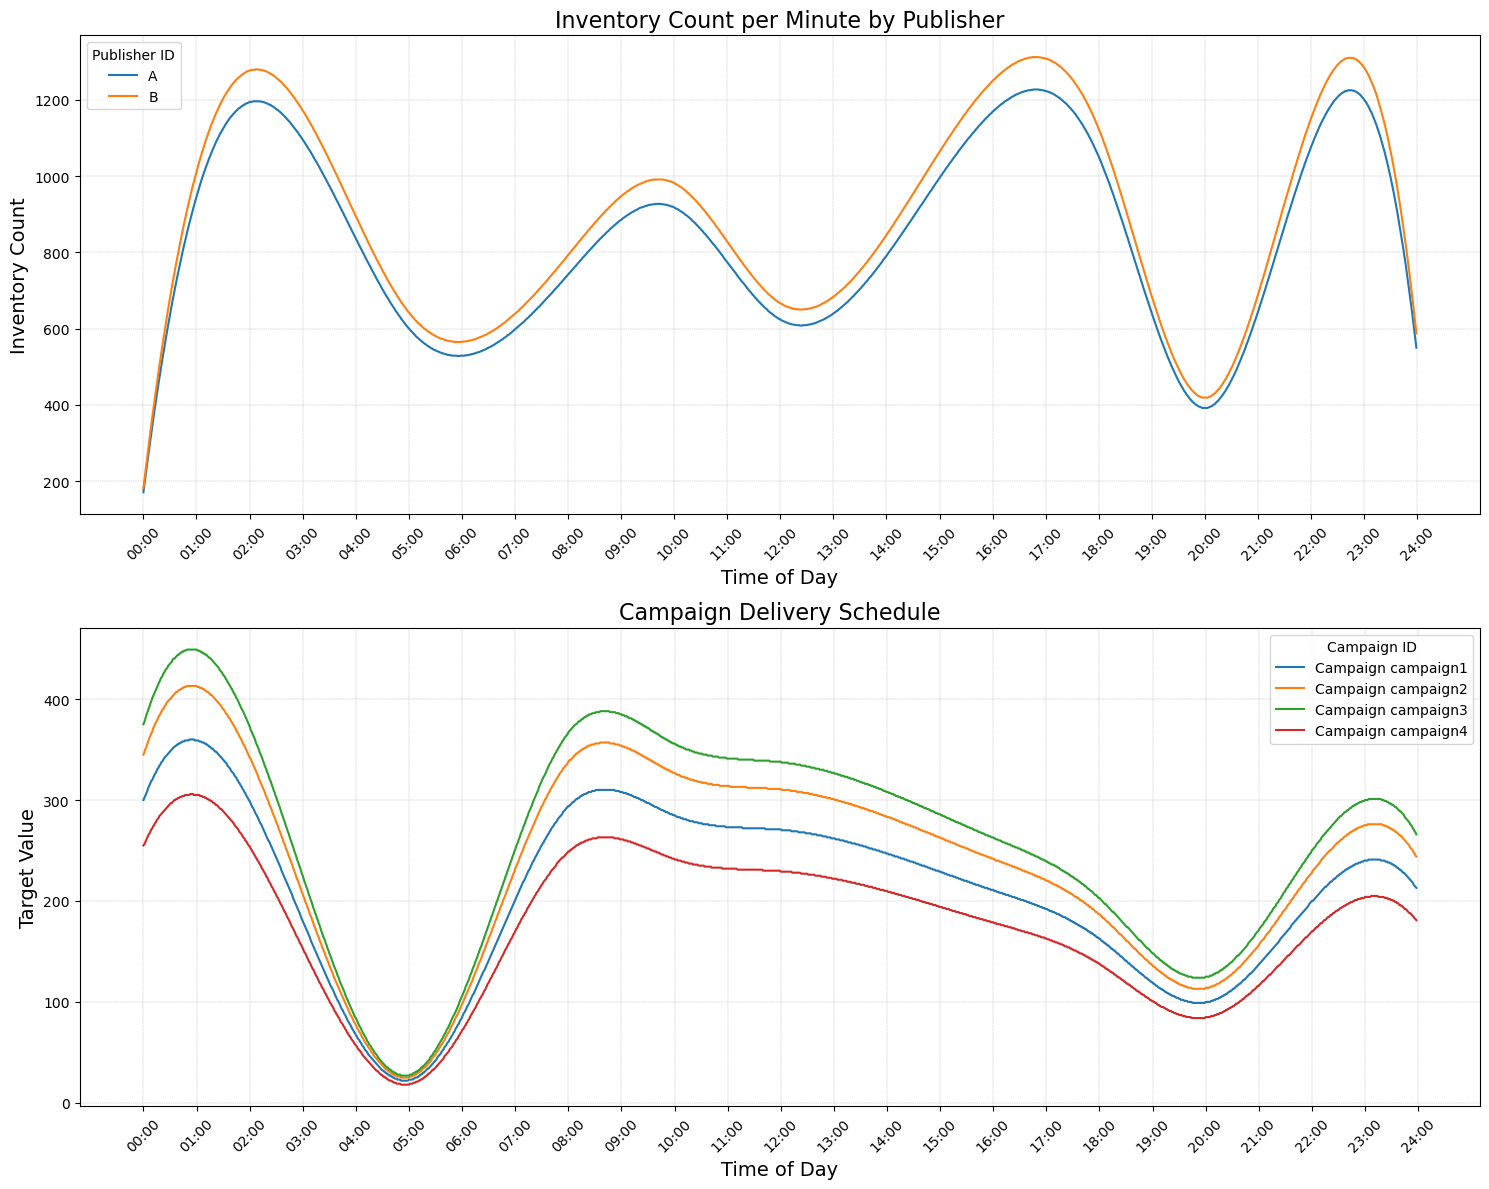

CPU times: user 590 ms, sys: 45.8 ms, total: 636 ms
Wall time: 698 ms


In [13]:
%%time
results = ResultsAnalysis(simulation)
results.plot_inventories_curve(False)

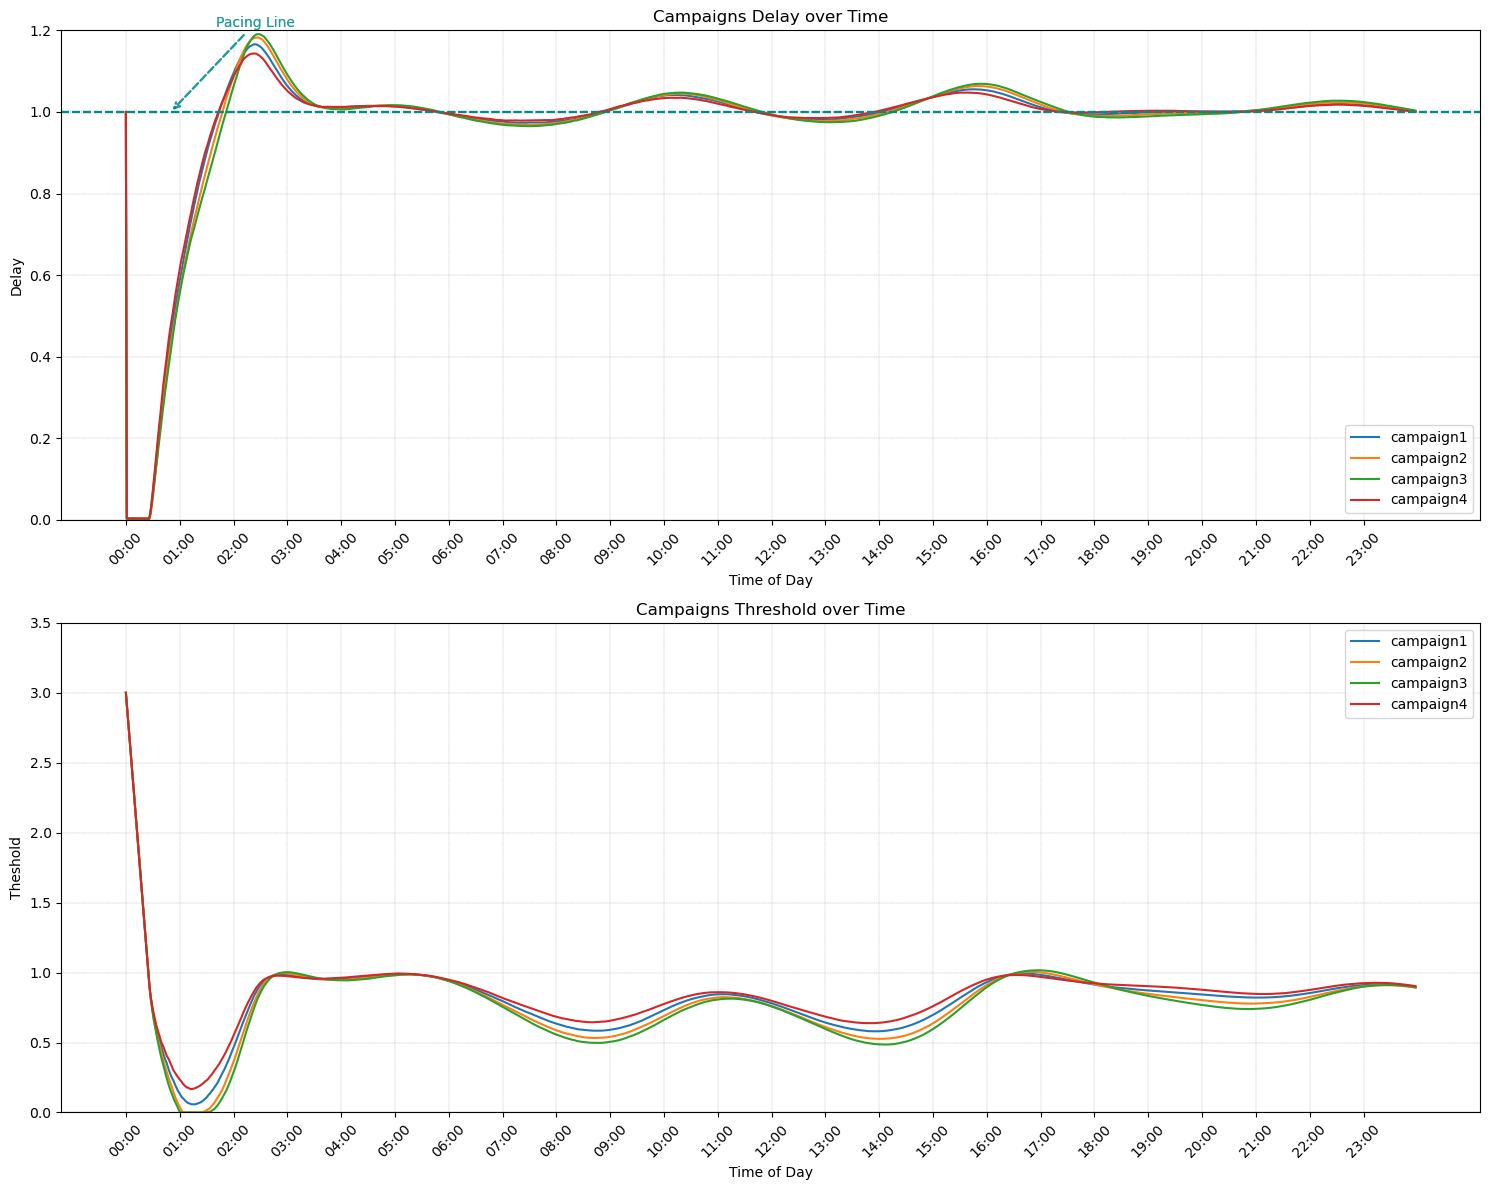

CPU times: user 510 ms, sys: 17.4 ms, total: 527 ms
Wall time: 527 ms


In [14]:
%%time
results.subplot_campaigns_evolution(
    item_ids=campaigns,
    logscale=False,
)

## Exclusive Privileges for one campaign

##### Generate requests curves

In [15]:
%%time
## define campaigns eligibility during the day
campaigns = ['campaign1', 'campaign2', 'campaign3', 'campaign4']


eligibities2 = [
    Eligibility(publisher='A', from_time='00:00', to_time='23:59', eligible_campaigns=campaigns),
    Eligibility(publisher='B', from_time='00:00', to_time='23:59', eligible_campaigns=['campaign4'])
]

inv_sample1 = [
     SampleSchedule(time='00:00', nb_expected=171),
     SampleSchedule(time='02:00', nb_expected=1194),
     SampleSchedule(time='05:00', nb_expected=601),
     SampleSchedule(time='08:00', nb_expected=742),
     SampleSchedule(time='10:00', nb_expected=918),
     SampleSchedule(time='12:00', nb_expected=624),
     SampleSchedule(time='16:00', nb_expected=1169),
     SampleSchedule(time='18:00', nb_expected=1051),
     SampleSchedule(time='20:00', nb_expected=392),
     SampleSchedule(time='22:00', nb_expected=1077),
     SampleSchedule(time='23:59', nb_expected=550),
 ]

inv_sample2 = [
    SampleSchedule(time=s.time, nb_expected=int(s.nb_expected * 1.07)) 
    for s in inv_sample1
]

invs1 = mocked_data.generate_inventory_schedule(publisher='A', inventories_sample=inv_sample1)
invs2 = mocked_data.generate_inventory_schedule(publisher='B', inventories_sample=inv_sample2)


## df requests
df_requests2 = mocked_data.generate_requests(
    delivery_inventories=[invs1, invs2], 
    eligibility_publishers=eligibities2
)

  0%|          | 0/1440 [00:00<?, ?it/s]

CPU times: user 17.9 s, sys: 545 ms, total: 18.4 s
Wall time: 18.4 s


##### Run delivery simulation

In [16]:
%%time
# simulation
simulation = Simulation(df_expected, df_requests2)
simulation.run_simulation()

Minute 0 done, with 353 reqs
=> stats - 0 imps
Minute 100 done, with 2397 reqs
=> stats - 1434 imps
Minute 200 done, with 2107 reqs
=> stats - 1112 imps
Minute 300 done, with 1244 reqs
=> stats - 495 imps
Minute 400 done, with 1165 reqs
=> stats - 139 imps
Minute 500 done, with 1643 reqs
=> stats - 946 imps
Minute 600 done, with 1900 reqs
=> stats - 1120 imps
Minute 700 done, with 1367 reqs
=> stats - 834 imps
Minute 800 done, with 1405 reqs
=> stats - 903 imps
Minute 900 done, with 2059 reqs
=> stats - 1130 imps
Minute 1000 done, with 2535 reqs
=> stats - 1331 imps
Minute 1100 done, with 1918 reqs
=> stats - 1033 imps
Minute 1200 done, with 811 reqs
=> stats - 452 imps
Minute 1300 done, with 1951 reqs
=> stats - 1094 imps
Minute 1400 done, with 2254 reqs
=> stats - 1214 imps
CPU times: user 10.9 s, sys: 27.2 ms, total: 11 s
Wall time: 11 s


##### Results analysis

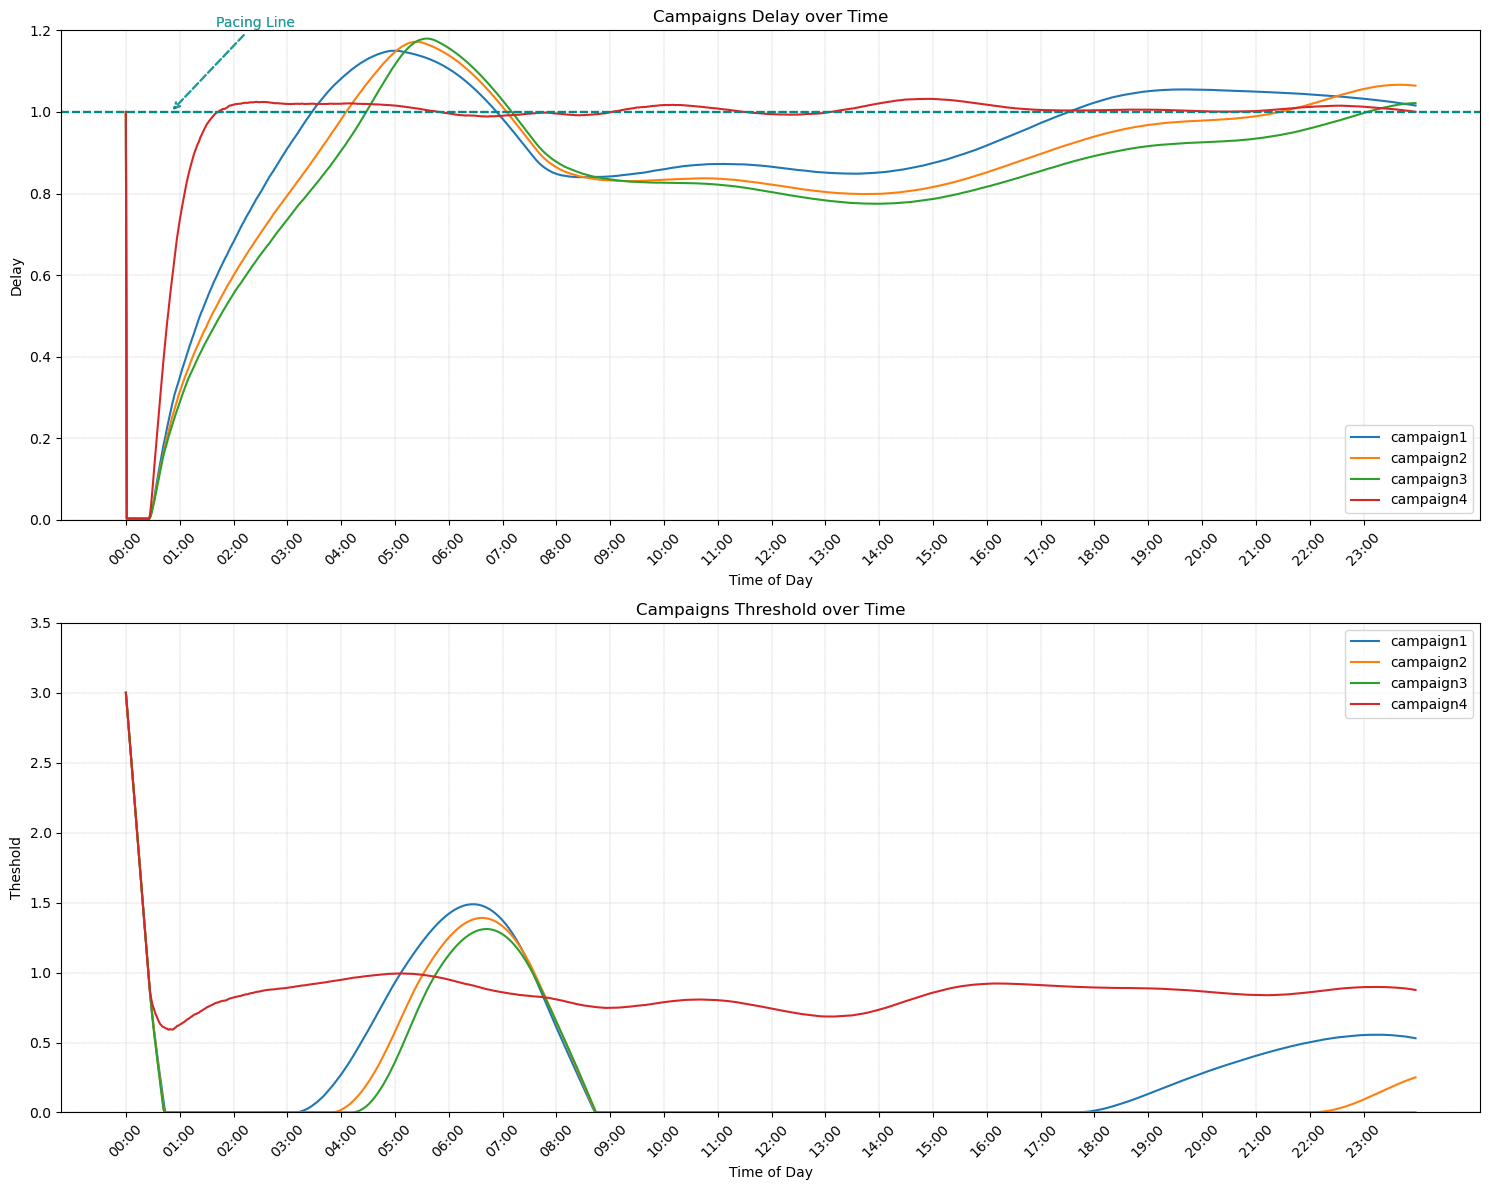

CPU times: user 507 ms, sys: 16.7 ms, total: 524 ms
Wall time: 522 ms


In [17]:
%%time
results = ResultsAnalysis(simulation)
results.subplot_campaigns_evolution(
    item_ids=campaigns,
    logscale=False,
)

## New Campaigns added


##### Generate campaign curve



In [18]:
%%time
# create data generator entity
mocked_data = MockData(1440)

# create sample schedule for cmp5
cmp_schedule_sample5 = [
     SampleSchedule(time='10:00', nb_expected=int(285*1.85)),
     SampleSchedule(time='12:00', nb_expected=int(271*1.85)),
     SampleSchedule(time='16:00', nb_expected=int(211*1.85)),
     SampleSchedule(time='18:00', nb_expected=int(163*1.85)),
     SampleSchedule(time='20:00', nb_expected=int(100*1.85)),
     SampleSchedule(time='22:00', nb_expected=int(200*1.85)),
     SampleSchedule(time='23:59', nb_expected=int(212*1.85)),
]

# create sample schedule for cmp6
cmp_schedule_sample6 = [
     SampleSchedule(time='18:00', nb_expected=210*2),
     SampleSchedule(time='20:00', nb_expected=97*2),
     SampleSchedule(time='22:00', nb_expected=200*2),
     SampleSchedule(time='23:59', nb_expected=212*2),
]


# generate campaigns schedule (for 6 campaigns)
cmp_schedule5 = mocked_data.generate_campaign_schedule(cmp_schedule_sample5, 'campaign5', start_time='10:00')
cmp_schedule6 = mocked_data.generate_campaign_schedule(cmp_schedule_sample6, 'campaign6', start_time='18:00')

df_expected3 = pd.DataFrame([
    cmp_schedule1, cmp_schedule2, 
    cmp_schedule3, cmp_schedule4,
    cmp_schedule5, cmp_schedule6
])


CPU times: user 23.4 ms, sys: 7.83 ms, total: 31.3 ms
Wall time: 24.6 ms


##### Generate requests curves

In [19]:
%%time
## define campaigns eligibility during the day
campaigns2 = campaigns + ['campaign5', 'campaign6']


eligibities3 = [
    Eligibility(publisher='A', from_time='00:00', to_time='24:00', eligible_campaigns=campaigns2),
    Eligibility(publisher='B', from_time='00:00', to_time='24:00', eligible_campaigns=['campaign4', 'campaign5', 'campaign6'])
]


## df requests
df_requests3 = mocked_data.generate_requests(
    delivery_inventories=[invs1, invs2], 
    eligibility_publishers=eligibities3
)


  0%|          | 0/1440 [00:00<?, ?it/s]

CPU times: user 22.7 s, sys: 849 ms, total: 23.6 s
Wall time: 23.5 s


##### Run delivery simulation

In [20]:
%%time
# simulation
simulation = Simulation(df_expected3, df_requests3)
simulation.run_simulation()

Minute 0 done, with 353 reqs
=> stats - 0 imps
Minute 100 done, with 2397 reqs
=> stats - 1448 imps
Minute 200 done, with 2107 reqs
=> stats - 1128 imps
Minute 300 done, with 1244 reqs
=> stats - 494 imps
Minute 400 done, with 1165 reqs
=> stats - 144 imps
Minute 500 done, with 1643 reqs
=> stats - 937 imps
Minute 600 done, with 1900 reqs
=> stats - 1137 imps
Minute 700 done, with 1367 reqs
=> stats - 1249 imps
Minute 800 done, with 1405 reqs
=> stats - 1341 imps
Minute 900 done, with 2059 reqs
=> stats - 1533 imps
Minute 1000 done, with 2535 reqs
=> stats - 1476 imps
Minute 1100 done, with 1918 reqs
=> stats - 1462 imps
Minute 1200 done, with 811 reqs
=> stats - 722 imps
Minute 1300 done, with 1951 reqs
=> stats - 1776 imps
Minute 1400 done, with 2254 reqs
=> stats - 1840 imps
CPU times: user 14.8 s, sys: 34.9 ms, total: 14.8 s
Wall time: 14.8 s


##### Results analysis



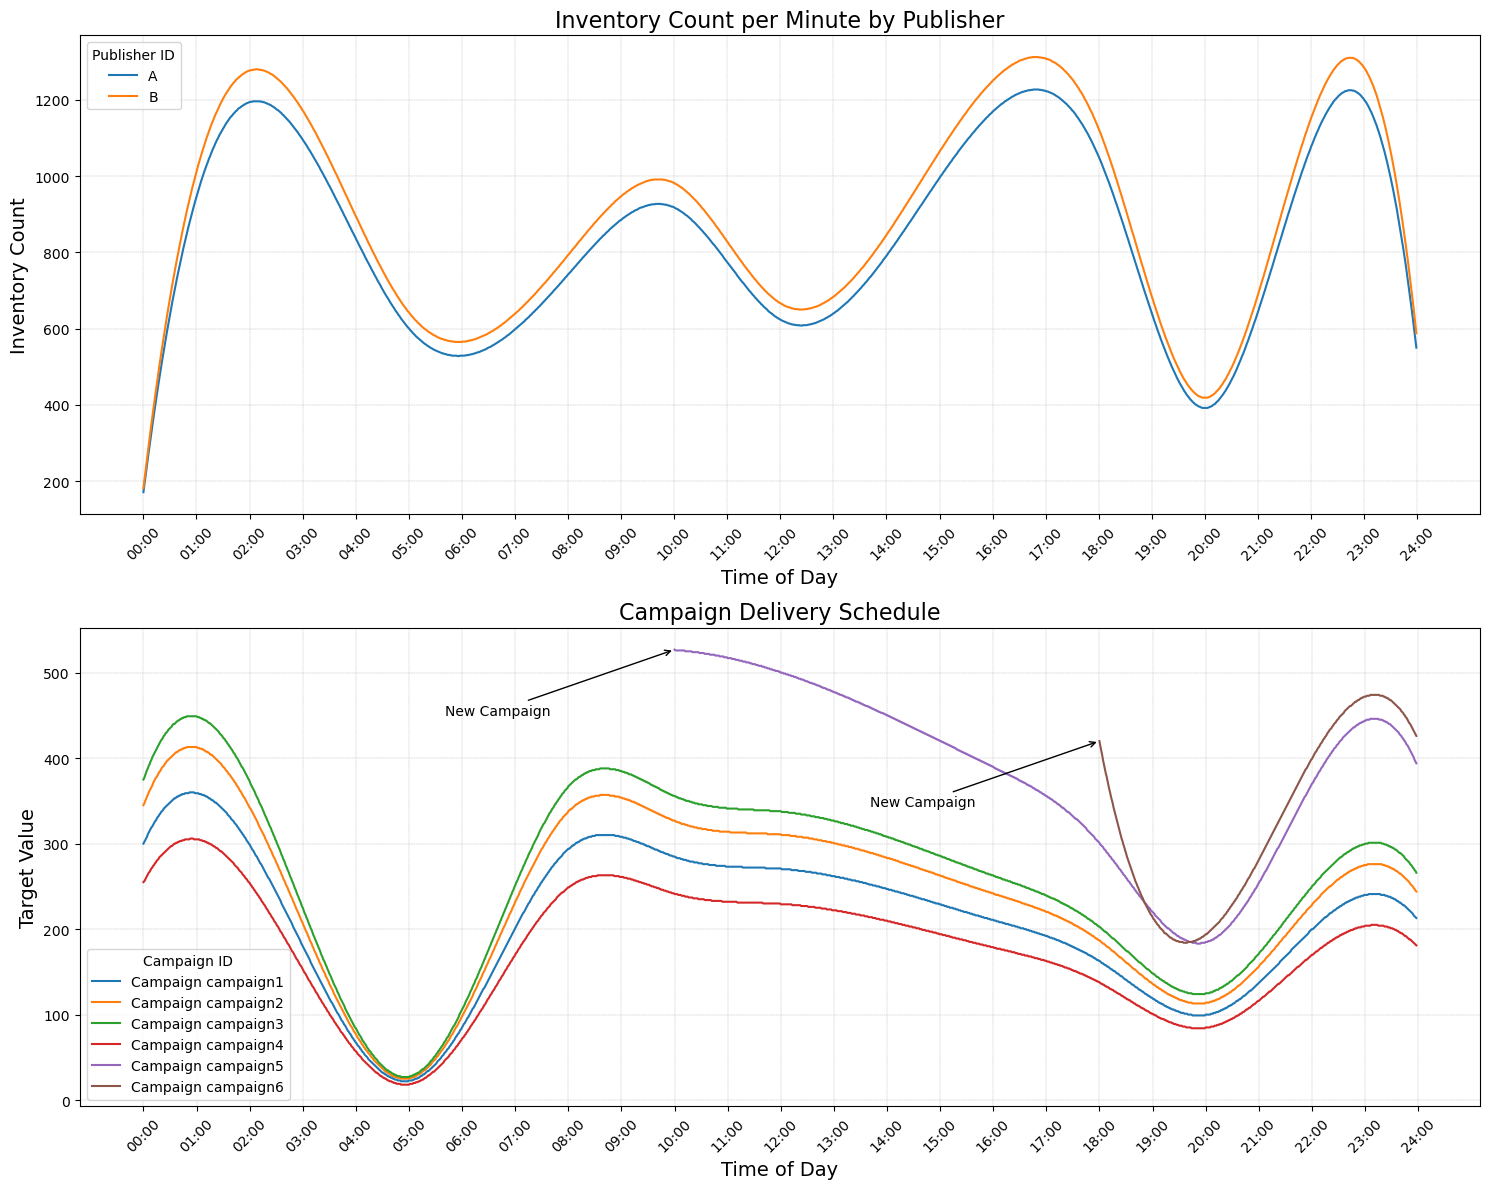

CPU times: user 665 ms, sys: 45.1 ms, total: 711 ms
Wall time: 710 ms


In [21]:
%%time
results = ResultsAnalysis(simulation)
results.plot_inventories_curve(False)

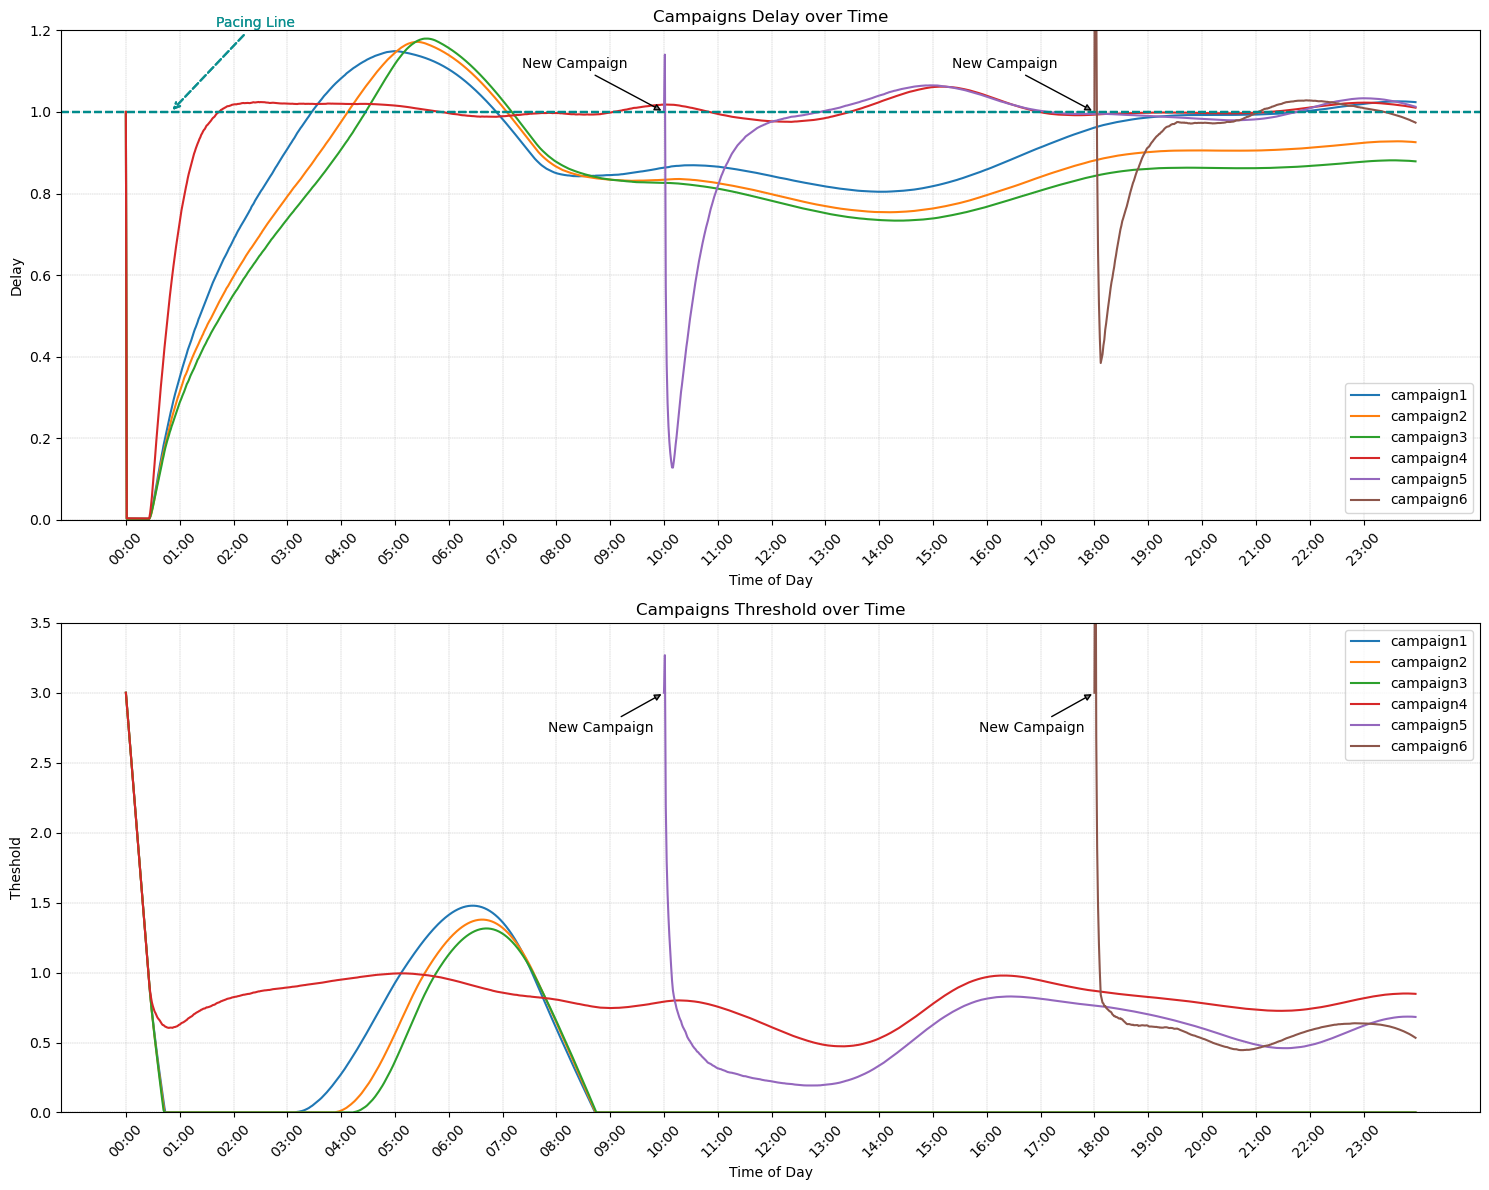

In [22]:
results.subplot_campaigns_evolution(
    item_ids=campaigns2,
    logscale=False,
)

## Stopped Campaigns

##### Generate campaign curve


In [23]:
%%time
# create data generator entity
mocked_data = MockData(1440)

cmp_schedule1_updated = mocked_data.generate_campaign_schedule(cmp_schedule_sample1, 'campaign1', end_time='21:00')
cmp_schedule2_updated = mocked_data.generate_campaign_schedule(cmp_schedule_sample2, 'campaign2', end_time='15:00')


df_expected4 = pd.DataFrame([
    cmp_schedule1_updated, cmp_schedule2_updated, 
    cmp_schedule3, cmp_schedule4,
    cmp_schedule5, cmp_schedule6
])


CPU times: user 36 ms, sys: 5.86 ms, total: 41.9 ms
Wall time: 36.8 ms


##### Generate requests curves




##### Run delivery simulation


In [24]:
%%time
# simulation
simulation = Simulation(df_expected4, df_requests3)
simulation.run_simulation()

Minute 0 done, with 353 reqs
=> stats - 0 imps
Minute 100 done, with 2397 reqs
=> stats - 1446 imps
Minute 200 done, with 2107 reqs
=> stats - 1128 imps
Minute 300 done, with 1244 reqs
=> stats - 492 imps
Minute 400 done, with 1165 reqs
=> stats - 144 imps
Minute 500 done, with 1643 reqs
=> stats - 935 imps
Minute 600 done, with 1900 reqs
=> stats - 1137 imps
Minute 700 done, with 1367 reqs
=> stats - 1249 imps
Minute 800 done, with 1405 reqs
=> stats - 1344 imps
Minute 900 done, with 2059 reqs
=> stats - 1530 imps
Minute 1000 done, with 2535 reqs
=> stats - 1476 imps
Minute 1100 done, with 1918 reqs
=> stats - 1462 imps
Minute 1200 done, with 811 reqs
=> stats - 719 imps
Minute 1300 done, with 1951 reqs
=> stats - 1743 imps
Minute 1400 done, with 2254 reqs
=> stats - 1722 imps
CPU times: user 15 s, sys: 28 ms, total: 15 s
Wall time: 15 s


##### Results analysis


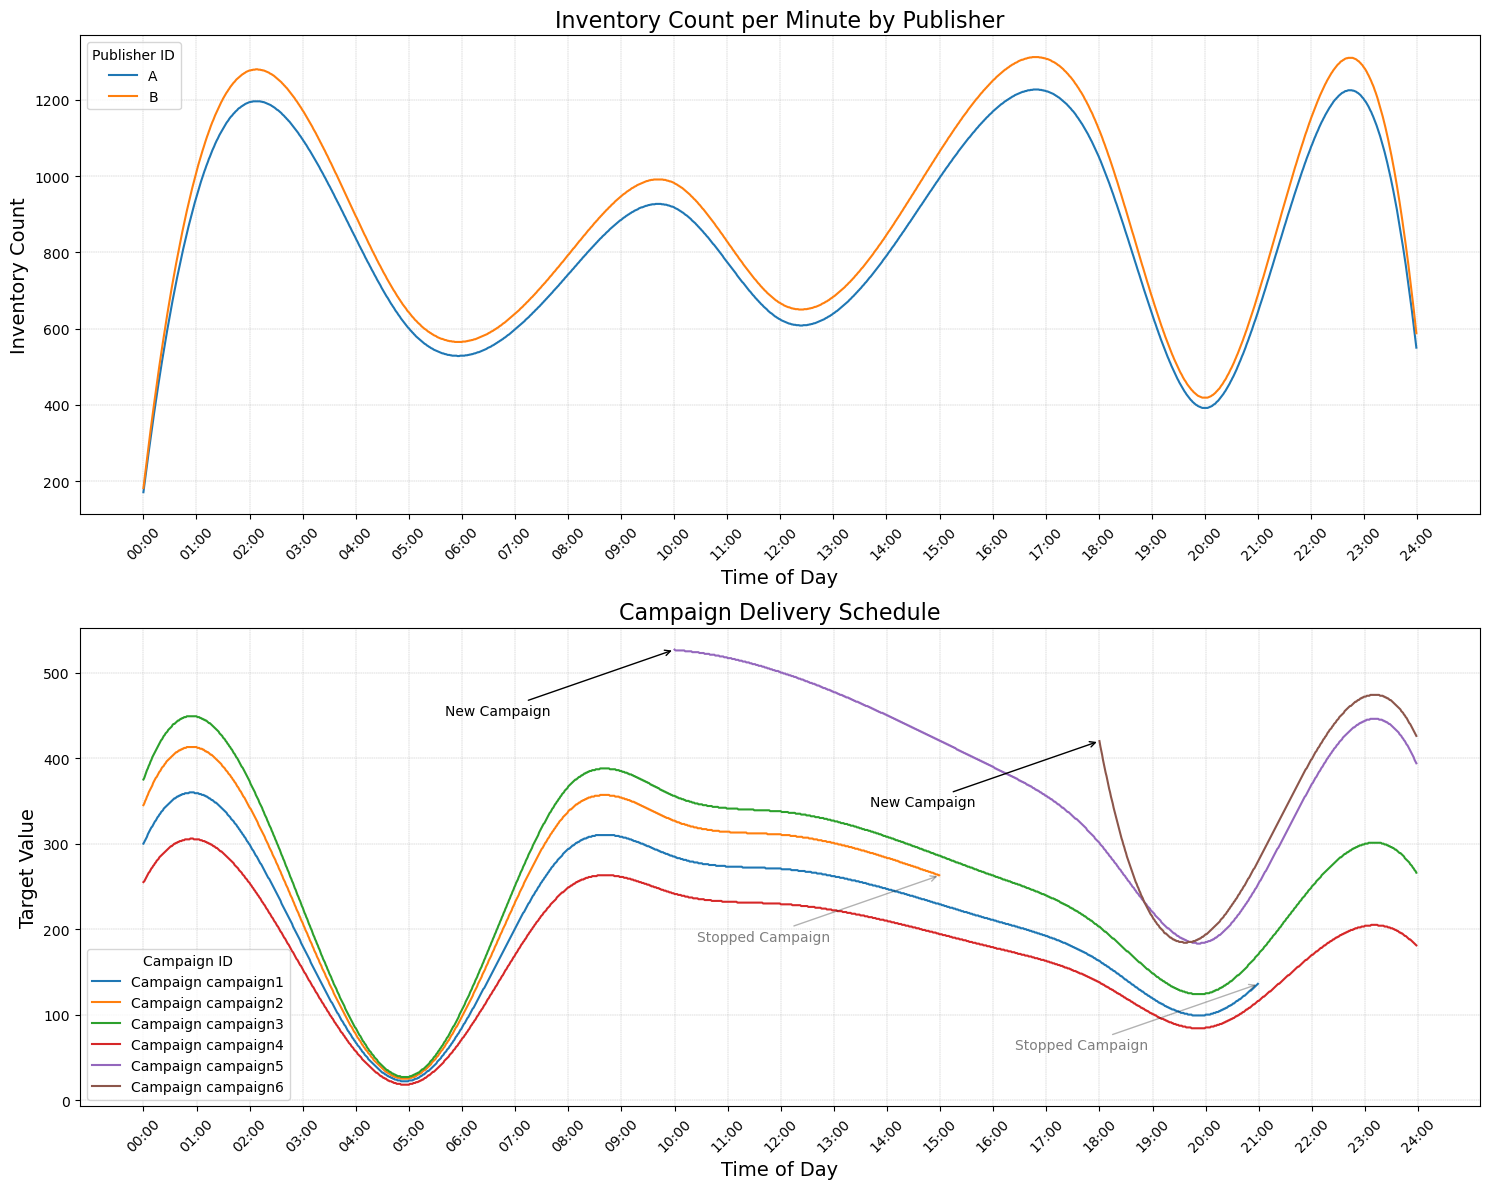

CPU times: user 723 ms, sys: 25.7 ms, total: 748 ms
Wall time: 747 ms


In [25]:
%%time
results = ResultsAnalysis(simulation)
results.plot_inventories_curve(False)

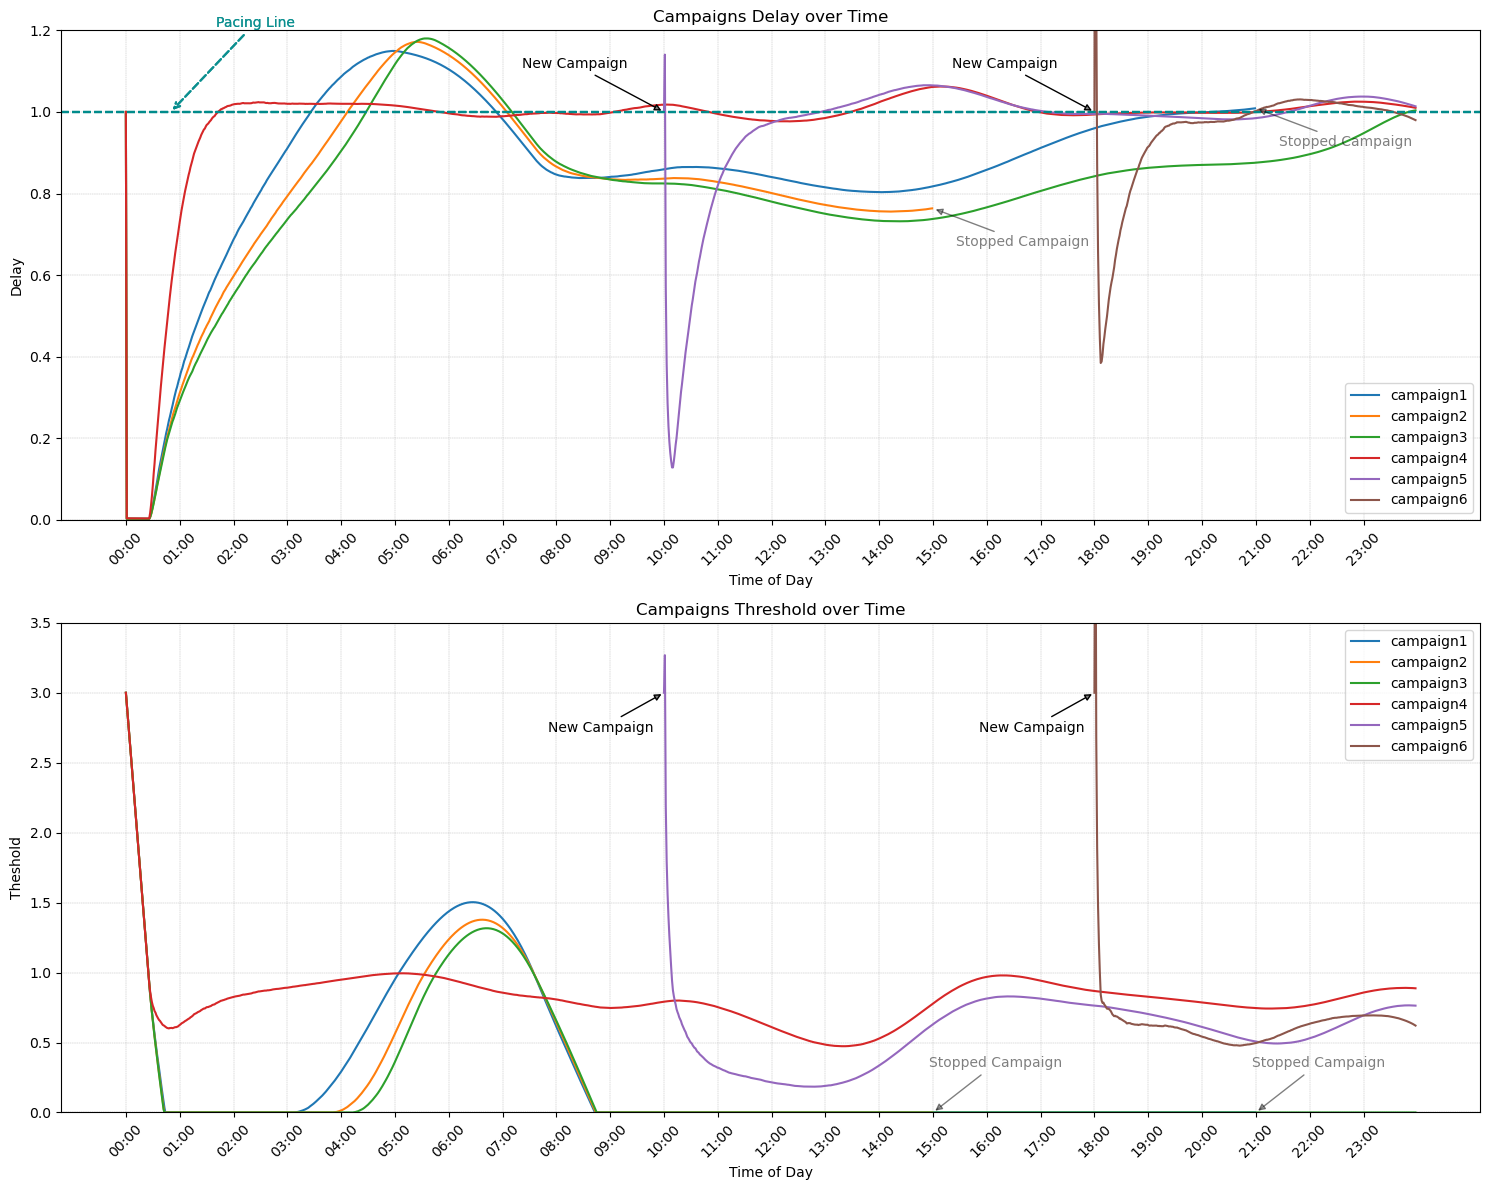

In [26]:
results.subplot_campaigns_evolution(
    item_ids=campaigns2,
    logscale=False
)